In [2]:
# Basic math libraries
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import math
from matplotlib import pyplot as plt
import pickle

# Matrix eigendecomposition
import numpy.linalg as lg
import scipy.linalg as slg

# Networks and Graphs
import networkx as nx
import dynetx as dn

# Random data generation
import itertools
import random
from collections import Counter
from random import randint
from itertools import chain

# Neural Networks
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

%load_ext autoreload
%autoreload 2

# Import Network and Signal

### Import network

In [2]:
# Import the multilayer dynamic network from file

L_file = np.load("datasets/outputs/multilayer_dynamic_network.npy", allow_pickle=True)
L_file = [[L_file[t][s] for s in range(len(L_file[0]))] for t in range(len(L_file))]


# Import node position to be used for all plots

pos_name = "spring_layout"
pos = np.load("datasets/nodes position for plot/position_network_" + pos_name + ".npy", allow_pickle=True).item()

In [3]:
# SET GRAPH NUMBERS

N = len(L_file[0][0])                                              # number of nodes
S = len(L_file[0])                                                 # number of layers (dyn + static)
layer_names = ['Hospital', 'Workplace', 'Random', 'School', 'Household']

T_file = len(L_file)
T_periodicity = 2
T = T_file * T_periodicity                                          # number of days 
L = L_file * T_periodicity

print("T =", T, "\nS =", S, "\nN =", N)

T = 56 
S = 5 
N = 500


In [4]:
# SET COVID NUMBERS

infection_threshold = 0.8                                     # signal value over which a person is considered sick
max_sickness_duration = 10                                    # days of maximum duration of the illness
min_immunization_duration = 60                                # days of immunization after having taken the virus

In [55]:
# functions to plot the multilayer dynamic network

def plot_dynamic_network(L_dynamic, n_snapshots_to_print, remove_isolated, layer_name, node_color, ax, index):      
    days_to_display = [round( (T)*i/(n_snapshots_to_print-1)) for i in range(0, n_snapshots_to_print-1)] + [T-1]
    days_to_display.sort()
    
    for idx, val in enumerate(days_to_display):
        l = L_dynamic[val]
        graph_to_display = nx.from_numpy_matrix(-l + np.diag(np.diag(l)))
#         if idx == 0:
#             pos=nx.spring_layout(graph_to_display)     # to use the pos defined outside from file
        if remove_isolated == True:
            graph_to_display.remove_nodes_from(list(nx.isolates(graph_to_display)))
        if type(node_color)==np.ndarray:
            node_color_c=node_color[val]
        else:
            node_color_c = node_color
        nx.draw_networkx_nodes(graph_to_display, pos=pos, node_size=50, node_color=node_color_c, ax=ax[3*index+idx]) # cmap=MyCmap,
        nx.draw_networkx_edges(graph_to_display, pos=pos, width=0.5, edge_color='grey', ax=ax[3*index+idx])
        ax[3*index+idx].set_title(layer_name+" contacts at day: "+str(val), fontsize=13)
        ax[3*index+idx].axis("off")
    

def plot_multilayer_dynamic_network(L, n_snapshots_to_print, layer_names, nodes_color, remove_isolated):
    lap_to_plot = [[L[t][s] for t in range(T)] for s in range(S)]
    
    fig, axes = plt.subplots(nrows=len(layer_names), ncols=n_snapshots_to_print, figsize = [18, 18])
#     axes.axis("off")
    ax = axes.flatten()  
    
    for i, layer_name in enumerate(layer_names):  
        plot_dynamic_network(lap_to_plot[i], n_snapshots_to_print, remove_isolated[i], layer_name, nodes_color[i], ax, index=i)
    plt.show()

/home/cozzani/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/cozzani/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/cozzani/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/cozzani/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/cozzani/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/cozzani/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstanc

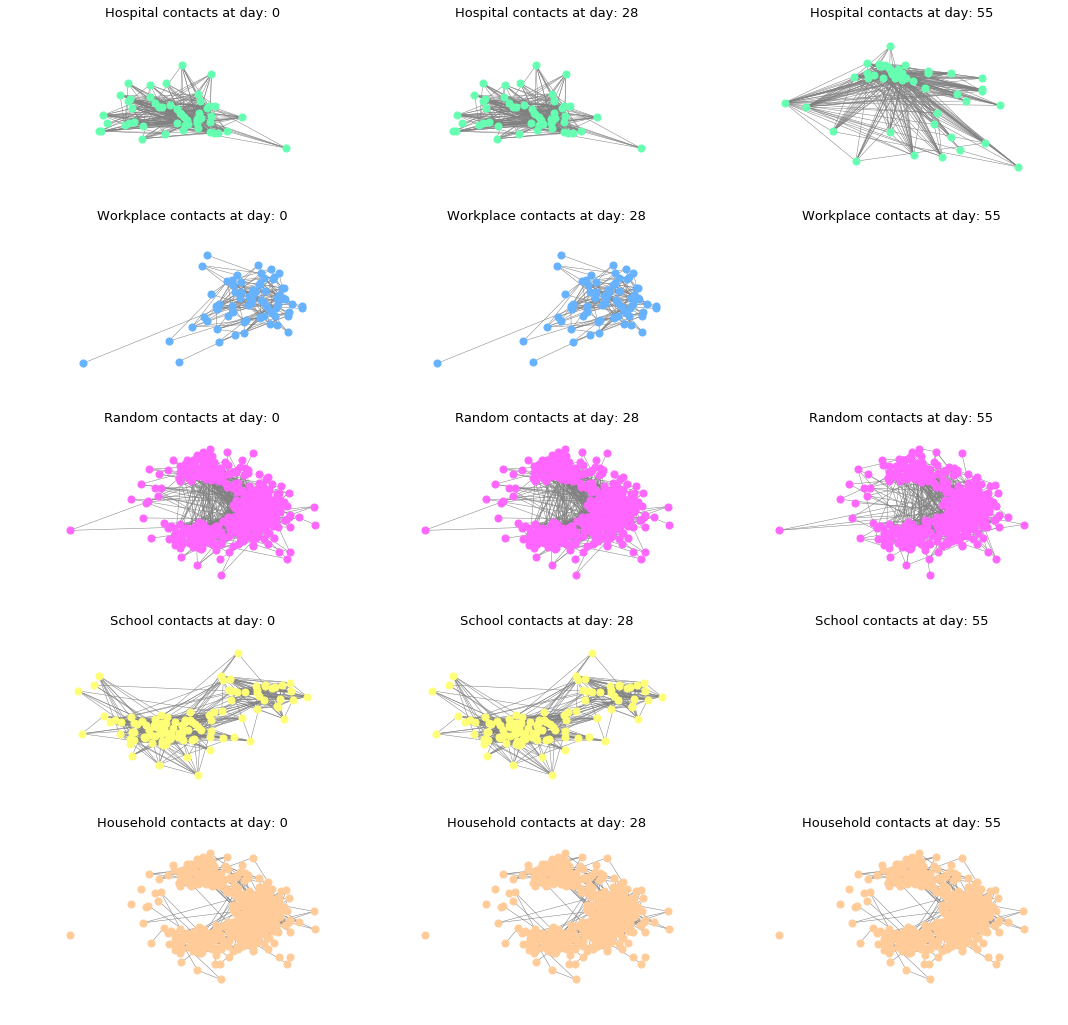

In [56]:
# plot the multilayer dynamic network

n_snapshots_to_print = 3
layer_names = ['Hospital', 'Workplace', 'Random', 'School', 'Household']
nodes_color = ['#66FFB2', '#66B2FF', '#FF66FF', '#FFFF77', '#FFCC99']
remove_isolated = [True, True, True, True, False]

plot_multilayer_dynamic_network(L, n_snapshots_to_print, layer_names, nodes_color, remove_isolated)

### Laplacian aggregation

In [7]:
# Import the aggregated dynamic network from file

L_file = np.load("datasets/outputs/aggregated_dynamic_network.npy", allow_pickle=True)
L_agg = [np.matrix(L_file[t]) for t in range(len(L_file))]
print(len(L_agg), L_agg[0].shape)

56 (500, 500)


In [8]:
# function to build a graph given a laplacian matrix

def graph_from_laplacian(L):
    A = -L
    np.fill_diagonal(A, 0)
    A_ = np.maximum(A, 0)
    G = nx.from_numpy_matrix(A_)
    return G

/home/cozzani/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/cozzani/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/cozzani/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/cozzani/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


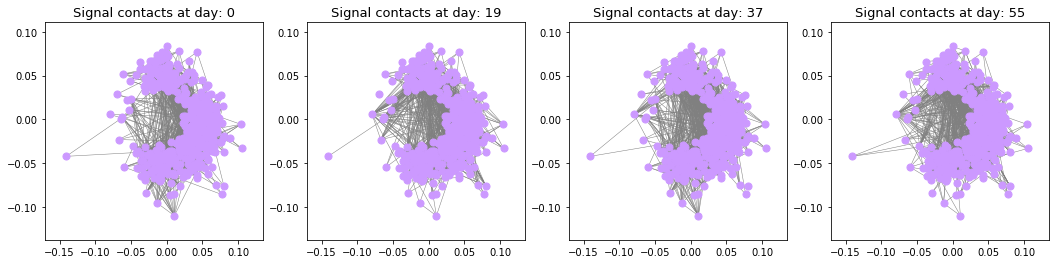

In [9]:
# Create aggregated graph G_agg

G_agg = [graph_from_laplacian(L_agg[t]) for t in range(T)]
pos_agg = nx.spring_layout(G_agg[0])


# Plot the aggregated graph

n_snapshots_to_print=4
fig, axes = plt.subplots(nrows=1, ncols=n_snapshots_to_print, figsize = [18, 4])
ax=axes.flatten()
plot_dynamic_network(L_agg, n_snapshots_to_print, node_color='#CC99FF', remove_isolated=False, layer_name = "Signal", ax =ax, index=0)

### Import signal

In [10]:
# Import COVID signal from file

signal_time, bool_signal_time = np.load("datasets/outputs/inferred_signal.npy", allow_pickle=True)


# Import values of Tau:

kind_of_filter, tau = np.load("datasets/outputs/inferred_filters_and_tau.npy", allow_pickle=True)

In [11]:
print("Layers: ", layer_names, "\nFilters: ", kind_of_filter, "\nTau param:", tau)

Layers:  ['Hospital', 'Workplace', 'Random', 'School', 'Household'] 
Filters:  ['heat' 'heat' 'heat' 'heat' 'heat'] 
Tau param: [0.27755243 0.09961079 0.16747989 0.03570133 0.24148309]


/home/cozzani/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/cozzani/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/cozzani/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/cozzani/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/cozzani/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/cozzani/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstanc

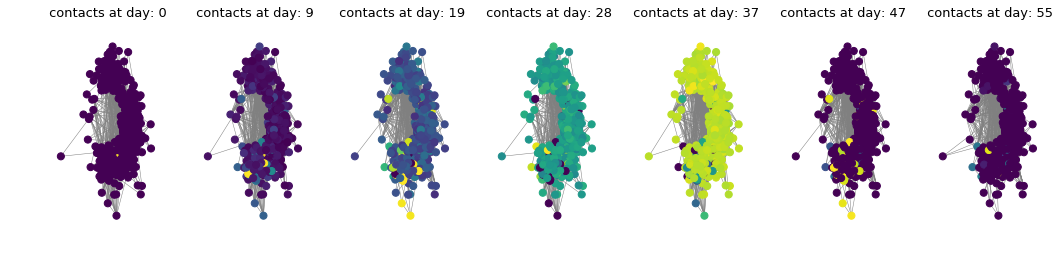

In [58]:
# Plot signal

n_snapshots_to_print = 7
fig, axes = plt.subplots(nrows=1, ncols=n_snapshots_to_print, figsize = [18, 4])
plot_dynamic_network(L_agg, n_snapshots_to_print, remove_isolated=False, layer_name="", node_color=signal_time, ax=axes.flatten(), index=0)

# [ML] COVID spread diffusion model (find unknown filter)

### NN class definition

In [13]:
def build_net(input_dim, hidden_dim, output_dim):
    random.seed(42)
    np.random.seed(42)
    torch.manual_seed(42)
    
    net = nn.Sequential(
        nn.Linear(input_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim//2),
        nn.ReLU(),
        nn.Linear(hidden_dim//2, hidden_dim//3),
        nn.ReLU(),
        nn.Linear(hidden_dim//3, hidden_dim//4),
        nn.ReLU(),
        nn.Linear(hidden_dim//4, output_dim),
        nn.Softplus()
    )  
    return net

In [14]:
class LearnMultiFilter:
    
    def __init__(self, model, epochs, lr):
        self.model  = model
        self.epochs = epochs
        self.lr     = lr
        
    def fit(self, X, graph_L, beta): 
        self.setup(graph_L, beta)
        self.train(X)                                   
        
    def setup(self, graph_L, beta):                                   
        self.beta = torch.from_numpy(beta.astype(np.float32)).requires_grad_()
        V = []
        U = []
        L = []
        for t in range(T):
            v_t = []
            u_t = []
            l_t = []
            for s in range(S):
                v, u = lg.eigh(graph_L[t][s])
                v_t.append(torch.from_numpy(v.astype(np.float32)))
                u_t.append(torch.from_numpy(u.astype(np.float32)))
                l_t.append(torch.from_numpy(graph_L[t][s].astype(np.float32)))
            V.append(v_t)
            U.append(u_t)
            L.append(l_t)    
        self.V = V                                               # list of S arrays of eigenvalues of L
        self.U = U                                               # list of S arrays of eigenvectors of L
        self.L = L                                               # list of S laplacians, one for each layer of L
        self.sigmoid = nn.Sigmoid()
    
    
    def loss(self, X): 
        loss_over_all_intervals = 0
        for t in range(T-2):
            x_pre  = torch.from_numpy(X[t].astype(np.float32))        # input signal at previous timestamp
            x_post = torch.from_numpy(X[t+1].astype(np.float32))      # input signal of the next timestamp
                   
            # calculation of the new signal
            h_dot_m = []
            for s in range(S):
                NN_output = self.model(self.V[t][s]) 
                z = torch.diag(NN_output, diagonal=0)
                h = self.U[t][s].mm(z).mm(self.U[t][s].t())  
                h_dot_m.append(h.mv(x_pre))
            phi_output = phi( h_dot_m, weights=self.beta)
            X_thresholded = torch.min( torch.max(phi_output, torch.ones_like(phi_output)*(-88)), 
                                      torch.ones_like(phi_output)*(9))
            X_pred = self.sigmoid(X_thresholded) 
    
            # calculation of the cross entropy
            cross_log = - x_post * torch.log(X_pred) - (1-x_post) * torch.log(1-X_pred)
            loss_over_all_intervals += torch.sum(cross_log)
        return loss_over_all_intervals
    
    
    def train(self, X):
        optimizer = torch.optim.Adam( list(self.model.parameters()) + [self.beta] , lr=self.lr, amsgrad=True) 
        self.history = []
        self.model.train()
        for epoch in range(self.epochs+1):
            loss = self.loss(X)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            self.history.append(loss.item())
            
            if epoch == 0 or epoch % 100 == 0:
                print('Epoch {:4d}/{:d}: {:2.2f}'.format(epoch, self.epochs, loss.item()))  
                print('Beta',(self.beta.data).detach().numpy())
        self.model.eval()
        self.last_beta = self.beta.data
    
    def predict(self):                                # return the output of the trained NN, listed for each layer      
        NN_output = []
        for s in range(S):
            NN = self.model(self.V[-1][s]) 
            NN_output.append(NN)
        return NN_output
    
    def learned_beta(self):
        return self.last_beta


### Functions definition

In [15]:
def NN_prediction(last_known_signal, net, L):      
    last_known_signal = torch.from_numpy(last_known_signal.astype(np.float32))
    
    NN_output = net.predict()
    NN_eigenvalues = [ torch.diag(eigenval, diagonal=0)  for eigenval in NN_output]
            
    phi_input = []
    for s in range(len(NN_output)):  
        _, eigenvectors = lg.eigh(L[s])                           
        eigenvectors = torch.from_numpy(eigenvectors.astype(np.float32))
        h = eigenvectors.mm(NN_eigenvalues[s]).mm(eigenvectors.t())
        phi_input.append( h.mv(last_known_signal) )
        
    sigmoid = nn.Sigmoid()
    learned_beta = net.learned_beta()
    
    X_pred = sigmoid(phi(phi_input, learned_beta)) 
    X_pred = X_pred.data.numpy()
    X_pred_bool = [1.0 if x>infection_threshold else 0 for x in X_pred]    
    
    return X_pred, X_pred_bool, NN_output, learned_beta

In [16]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [17]:
# plot functions 

def plot_error(X_pred, X_pred_truth):
    
    ax = plt.subplot(111)
    t1 = np.arange(0.0, len(X_pred), 1)
    
    error = abs(X_pred - X_pred_truth)
    
    plt.plot(t1, X_pred_truth, 'g--', label="X_truth")
    plt.plot(t1, X_pred, 'y--', label="X_pred")
    plt.plot(t1, error, label="error", color='r')
    
    plt.xlabel('Signal components')
    plt.ylabel('Value of the component')
    plt.title('Predicted signal VS real signal')
    plt.legend()
    plt.show()

    
def print_static_network(L, layer_name = '', node_color='b', K='K'):
    graph_to_display = nx.from_numpy_matrix(-L + np.diag(np.diag(L)))
    pos=nx.spring_layout(graph_to_display)
    nx.draw_networkx_nodes(graph_to_display, pos=pos, node_size=70, node_color=node_color)
    nx.draw_networkx_edges(graph_to_display, pos=pos, width=0.5, edge_color='grey')
    plt.title(layer_name+" static layer with "+str(K)+" clusters", fontsize=13)
    plt.show()
    
    
def eigenvalues_comparison(NN_eigenvalues, L, kind_of_filter, tau, normalize = True):
    L = L[-1]
    t1 = np.arange(0.0, len(L[0]), 1)
    if len(L)==1:                           #in case or only one layer there is an error if using subplot with only 1 figure
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize = [18, 4])
    else:
        fig, axes = plt.subplots(nrows=1, ncols=len(L), figsize = [18, 4])
    ax = axes.flatten()
        
    for s in range(len(L)): 
        L_filtered_s = h_filter(L[s], kind_of_filter[s], tau[s])
        orig_eigenvalues, _ = lg.eigh(L[s])
        filtered_eigenvalues, _ = lg.eigh(L_filtered_s)
        NN_eigenval = NN_eigenvalues[s].detach().numpy()
        
        if normalize:
            orig_eigenvalues = NormalizeData(orig_eigenvalues)
            filtered_eigenvalues = NormalizeData(filtered_eigenvalues)
            NN_eigenval = NormalizeData(NN_eigenval)
            if s==0:
                print("The sets of eigenvalues are normalized in [0,1]")
        else:
            if s==0:
                print("The sets of eigenvalues are not normalized")
            
        orig_eigenvalues = np.sort(orig_eigenvalues)
        filtered_eigenvalues = np.sort(filtered_eigenvalues)
        NN_eigenval = np.sort(NN_eigenval)
        
        ax[s].plot(t1, NN_eigenval, 'y*', label="NN output")
        ax[s].plot(t1, filtered_eigenvalues, 'g*', label="L filtered eigenvalues")
        #ax[i].plot(t1, orig_eigenvalues, 'y*', label="L original eigenvalues")
    
        ax[s].legend()
        ax[s].set_title(kind_of_filter[s] + " filter" + ", layer n." + str(s+1))
    plt.show()  

In [18]:
# filters definition

def h_filter(laplacian, kind_of_filter, tau, **params):
    eigenvalues , eigenvectors = lg.eigh(laplacian)
   
    if kind_of_filter not in ("heat", "normal", "highpass"):
        print("kind_of_filter must be chosen between: normal, heat, highpass")
        return 0

    elif kind_of_filter == "heat":
        heat_diag = [np.exp(-tau*x) for x in eigenvalues]
        H_filter = np.diag(heat_diag)
        h_filter = eigenvectors.dot(H_filter).dot(eigenvectors.T)
   
    elif kind_of_filter == "normal":  
        alpha = 0.01
        eigenv = np.diag(eigenvalues) + alpha * np.eye(len(eigenvalues))  # regularization term, to avoid 0 values in the sqrt
        x_reg = lg.pinv(eigenv)
        h_filter = eigenvectors.dot(slg.sqrtm(x_reg)).dot(eigenvectors.T)
       
    elif kind_of_filter == "highpass":
        numerator = np.diag(eigenvalues)*tau
        denominator = lg.pinv(np.diag( [tau*x+1 for x in eigenvalues] ))
        H_filter = numerator.dot(denominator)
        h_filter = eigenvectors.dot(H_filter).dot(eigenvectors.T)
        
    return h_filter  

In [19]:
# function Phi to aggregate the layers as weighted sum

def phi(list_like, weights = None):                                   
    if weights is None and isinstance(list_like, torch.Tensor):
        weights = torch.ones(len(list_like))
    elif weights is None and isinstance(list_like, list):
        weights = np.ones(len(list_like))
    summ = []
    for s in range(len(list_like)):
        summ.append(list_like[s]*weights[s])
    return sum(summ) / sum(weights)

## Experiments
### Find representative filters for each layer

In [20]:
# NN model creation
model = build_net(input_dim = L[0][0].shape[0], hidden_dim = 250, output_dim = L[0][0].shape[0])


# variables definitions 
beta_initialization = np.array( [3, 3, 1, 2, 3] )  
split = T-7
L_train = L[:split]
L_test = L[split:]                                 #starting from index t=split
X_train = signal_time[:split]
X_test = signal_time[split:]                      #starting from index t=split



# NN training
T=split
net = LearnMultiFilter(model, epochs=500, lr=0.01)
net.fit(X_train, L_train, beta_initialization)   
T=split+7

/home/cozzani/anaconda3/lib/python3.7/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


Epoch    0/500: 15337.38
Beta [2.99 3.01 1.01 2.01 2.99]
Epoch  100/500: 14317.85
Beta [2.9319477 3.029281  1.5784461 1.8930783 2.5299594]
Epoch  200/500: 14252.85
Beta [2.9063704 3.0373168 1.5712578 1.9898566 2.4527912]
Epoch  300/500: 14230.52
Beta [2.8826754 3.0357392 1.5921983 2.0325074 2.4408772]
Epoch  400/500: 14218.39
Beta [2.8739727 3.0410666 1.6316781 2.0268636 2.4147158]
Epoch  500/500: 14228.21
Beta [2.9540627 3.122075  1.6017976 2.0750728 2.3253803]


In [21]:
# Calculate prediction 
_ ,_ , filter_eigenval, beta = NN_prediction(X_train[-1], net, L_train[-1])

X_pred = []
X_pred_bool = []
X_preceeding =[X_train[-1]] + list(X_test[:-1])
for t in range(len(X_test)):
    X_pred_t, X_pred_bool_t, filter_eigenval, beta = NN_prediction(X_preceeding[t], net, L_test[t])
    X_pred.append(X_pred_t)
    X_pred_bool.append(X_pred_bool_t)

### Save the prediction as file

In [22]:
# Save the predicted signals as list of signals in a .npy file

predicted_signal = [X_pred, X_pred_bool]  #, test_set_size]
np.save("datasets/outputs/predicted_signal.npy", predicted_signal)

### Prediction error

In [3]:
# TO RUN WITHOTU RUNNING ALL THE PREVIOUS, IMPORT THE FOLLOWING FILES:

# Import the multilayer dynamic network from file
L_file = np.load("datasets/outputs/multilayer_dynamic_network_500.npy", allow_pickle=True)
L_file = [[L_file[t][s] for s in range(len(L_file[0]))] for t in range(len(L_file))]


# Import the aggregated dynamic network from file
L_agg = np.load("datasets/outputs/aggregated_dynamic_network.npy", allow_pickle=True)
L_agg = [np.matrix(L_agg[t]) for t in range(len(L_agg))]


# Import node position to be used for all plots
pos_name = "kamada_kawai"
pos = np.load("datasets/nodes position for plot/position_network_" + pos_name + ".npy", allow_pickle=True).item()


# Import the predicted signals
X_pred, X_pred_bool = np.load("datasets/outputs/predicted_signal.npy", allow_pickle=True)


# Import the original signal
signal_time, bool_signal_time = np.load("datasets/outputs/inferred_signal.npy", allow_pickle=True)


# set numbers
N = len(L_file[0][0])                                              # number of nodes
S = len(L_file[0])                                                 # number of layers (dyn + static)
layer_names = ['Hospital', 'Workplace', 'Random', 'School', 'Household']
T_file = len(L_file)
T_periodicity = 2
T = T_file * T_periodicity                                          # number of days 
L = L_file * T_periodicity
print("T =", T, "\nS =", S, "\nN =", N)


# set test signals
split = T-7
X_test = signal_time[split:] 
X_test_bool = [ np.where(a > 0.5, 1, 0) for a in X_test]
len(signal_time),len(X_test),T-7,T,T_file

FileNotFoundError: [Errno 2] No such file or directory: 'datasets/outputs/multilayer_dynamic_network_500.npy'

In [4]:
# functions to plot static and dynamic signals over a network

def plot_network(G, weighted=False, pos=None, ax=None, figsize=(5,5), node_color='b', cmap= 'viridis', vmin=None, vmax=None):
    """plot a static weighted graph, eventually with nodes colored as a given signal"""
    if ax is None:
        plt.figure(figsize=figsize)
        plt.axis('off')
        ax = plt.gca()
    if pos is None:
        pos = nx.spring_layout(G) 
    emap = plt.cm.Greys if weighted else ListedColormap([(0,0,0)])
    nx.draw_networkx_nodes(G, pos, node_size=50, node_color=node_color, ax=ax, cmap=cmap, vmin=vmin, vmax=vmax)
    if weighted is True:
        edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
        weights = tuple(w*10 for w in weights)   
        nx.draw_networkx_edges(G, pos, width=0.5, edgelist=edges, edge_color=weights, edge_cmap=emap, ax=ax) 
    else:
        nx.draw_networkx_edges(G, pos=pos, width=0.5, edge_color='grey', ax=ax)   
    
def plot_dynamic_network(L_dynamic, n_snapshots_to_print=None, weighted=False, pos=None, node_color='b', cmap = 'viridis', vmin=None, vmax=None, time_shift=0):
    """plot all snapshots of a weighted graph, eventually with nodes colored as a given temporal signal"""
    T=len(L_dynamic)
    if isinstance(node_color, str):
        node_color = ([node_color]*T)
    if n_snapshots_to_print is None:
        days_to_display = list(range(T))
    else:
        days_to_display = [round( (T)*i/(n_snapshots_to_print)) for i in range(0, n_snapshots_to_print-1)] + [T-1]
        days_to_display.sort()
    
    fig, axes = plt.subplots(nrows=1, ncols=len(days_to_display), figsize = [18, 4])
    ax = axes.flatten()   
    for idx, val in enumerate(days_to_display):
        l = L_dynamic[val]
        graph_to_display = nx.from_numpy_matrix(-l + np.diag(np.diag(l)))
        if pos == None and idx==0:
            pos=nx.spring_layout(graph_to_display)
        plot_network(graph_to_display, weighted=weighted, pos=pos, ax=ax[idx], figsize=(5,5), node_color=node_color[val], cmap = cmap, vmin=vmin, vmax=vmax)
        ax[idx].set_title("Signal at day: "+str(val+time_shift), fontsize=13)
        ax[idx].axis("off")
    plt.show()

In [5]:
# predicted expansion   

global_vmin, global_vmax = np.matrix(X_pred+X_test).min(), np.matrix(X_pred+X_test).max()
L_plot = L_agg[split:]
plot_dynamic_network(L_plot, weighted=True, pos=pos, node_color=X_pred, cmap = 'YlOrBr', vmin=global_vmin, vmax=global_vmax, time_shift=split)

NameError: name 'X_pred' is not defined

In [6]:
# real expansion

plot_dynamic_network(L_plot, weighted=True, pos=pos, node_color=X_test, cmap = 'YlOrBr', vmin=global_vmin, vmax=global_vmax, time_shift=split)

NameError: name 'L_plot' is not defined

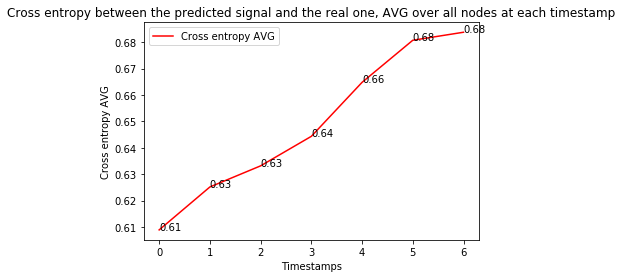

Cross log in Average:
 0.649


In [82]:
# cross entropy

def plot_error_cross(X_pred, X_truth):
    
    X_pred=np.array(X_pred)
    X_truth=np.array(X_truth)
    cross_log_time = []
    for t in range(len(X_pred)):
        cross_log_t = - X_truth[t] * np.log(X_pred[t]) - (1-X_truth[t]) * np.log(1-X_pred[t])
        cross_log_avg_nodes = sum(cross_log_t) / len(cross_log_t)
        cross_log_time.append(cross_log_avg_nodes)
    
    ax = plt.subplot(111)
    t1 = np.arange(0.0, len(X_pred), 1)
    plt.plot(t1, cross_log_time, label="Cross entropy AVG", color='r')
    plt.xlabel('Prediction timestamps')
    plt.ylabel('Cross entropy AVG')
    plt.title('Cross entropy between the predicted signal and the real one, AVG over all nodes at each timestamp')
    plt.legend()
    for a,b in zip(t_,cross_log_time): 
        plt.text(a, b, str(np.round(b,2)))
    plt.show()
    
    return cross_log_time

cross_log_time = plot_error_cross(X_pred_bool, X_test_bool)
print("Cross log in Average:\n", np.round(sum(cross_log_time) / len(cross_log_time),3))

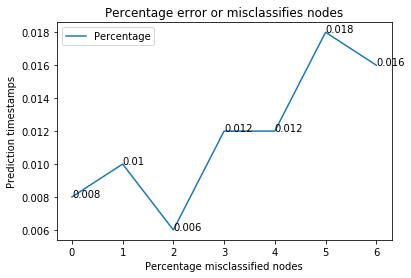

In [107]:
# percentage error

daily_error_percent = [ sum(   abs(np.array(X_pred_bool[t])-np.array(X_test_bool[t]))   )/N for t in range(len(X_pred_bool))]
t_=np.arange(0.0, len(X_pred), 1)
plt.plot(t_,daily_error_percent, label="Percentage")
for a,b in zip(t_,daily_error_percent): 
    plt.text(a, b, str(b))
plt.xlabel('Percentage misclassified nodes')
plt.ylabel('Prediction timestamps')
plt.title('Percentage error or misclassifies nodes')
plt.legend()
plt.show()

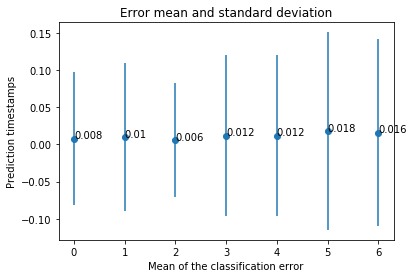

In [108]:
# mean and std of the error

error = abs(np.array(X_pred_bool) - np.array(X_test_bool))  

mean_time = np.mean(error, axis=1)
std_time = np.std(error, axis=1) 
t_=np.arange(0.0, len(X_pred), 1)

plt.errorbar(t_, mean_time, yerr=std_time, linestyle='None', fmt='-o')#, marker='-o')
for a,b in zip(t_,mean_time): 
    plt.text(a, b, str(b))
plt.title("Error mean and standard deviation")
plt.xlabel('Mean of the classification error')
plt.ylabel('Prediction timestamps')
plt.show()

### Others error measures

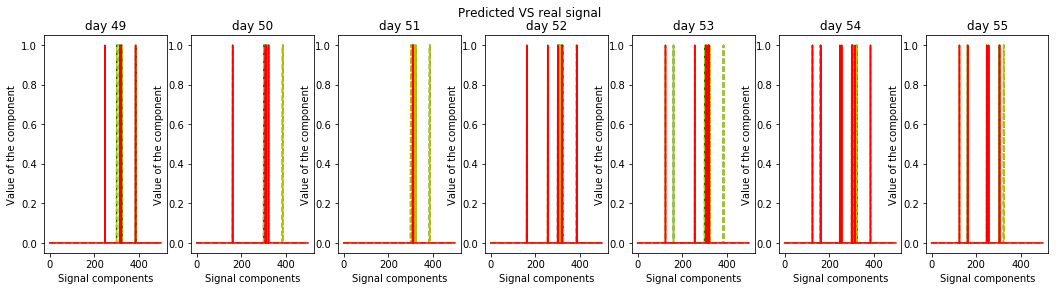

In [26]:
# other visualization of the error ( always as asb(diff(a,b)) but over the list of N nodes: 
# error (red), predicted signal (yellow), real signal (green) 

def plot_error(X_pred, X_pred_truth): 
    """plot the prediction and the truth for the next timestamps, adding a red line for the difference (error)"""
    t1 = np.arange(0.0, len(X_pred[0]), 1)  
    fig, axes = plt.subplots(nrows=1, ncols=len(X_pred), figsize = [18, 4])
    ax = axes.flatten()   
    for idx, axis in enumerate(axes):
        error = abs(X_pred[idx] - X_pred_truth[idx])   
        axis.plot(t1, X_pred_truth[idx], 'g--', label="truth")
        axis.plot(t1, X_pred[idx], 'y--', label="prediction")
        axis.plot(t1, error, label="error", color='r')    
        axis.set_xlabel('Signal components')
        axis.set_ylabel('Value of the component')
        axis.set_title('day '+str(idx+split))
    plt.suptitle('Predicted VS real signal\n')
    plt.show()

    
# plot

X_test_bool = [ np.where(a > 0.5, 1, 0) for a in X_test]
plot_error(np.array(X_pred_bool), np.array(X_test_bool))

In [28]:
# plot of beta

# beta = [3.0114162 , 3.1823423 , 3.0179775 , 1.2859846 , 0.41162586 , 1.2017347 ]
print("The learned weights Beta of each layer are:\n")
for i, name in enumerate(layer_names):  
    print("Beta =", beta[i], " for layer " + name)

The learned weights Beta of each layer are:

Beta = tensor(2.9541)  for layer Hospital
Beta = tensor(3.1221)  for layer Workplace
Beta = tensor(1.6018)  for layer Random
Beta = tensor(2.0751)  for layer School
Beta = tensor(2.3254)  for layer Household


In [ ]:
# cross entropy
# cross_log = - new_signal * (X_pred) - (1-new_signal) * (1-X_pred)

def plot_error_cross(X_pred, X_pred_truth):
    
    ax = plt.subplot(111)
    t1 = np.arange(0.0, len(X_pred), 1)
    
    error = (X_pred - X_pred_truth)   

    plt.plot(t1, error, label="cross entropy", color='r')
    plt.xlabel('Signal components')
    plt.ylabel('Value of the component')
    plt.title('Cross entropy between the predicted signal and the real one')
    plt.legend()
    plt.show()

for t in range(len(X_test)):
    plot_error_cross(- X_test[t] * np.log(X_pred[t]), (1-X_test[t]) * np.log(1-X_pred[t]))

<b>ROC curve</b>

Compute Receiver operating characteristic (ROC) for binary classification task.
Takes as input: 
1. True binary labels
2. Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of decisions (as returned by “decision_function” on some classifiers)

Return as output:
1. Array with increasing false positive rates such that element i is the false positive rate of predictions with score >= thresholds[i].
2. Array with increasing true positive rates such that element i is the true positive rate of predictions with score >= thresholds[i].
3. Array with decreasing thresholds on the decision function used to compute fpr and tpr. thresholds[0] represents no instances being predicted and is arbitrarily set to max(y_score) + 1.

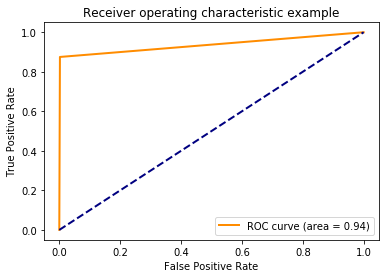

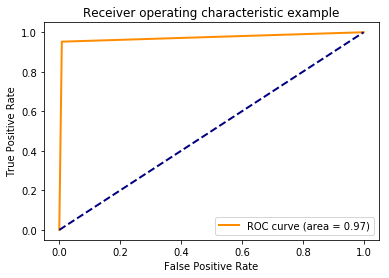

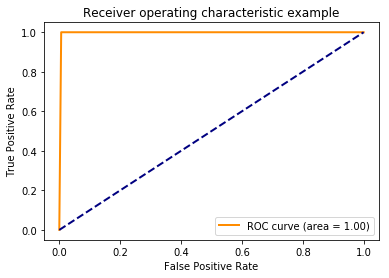

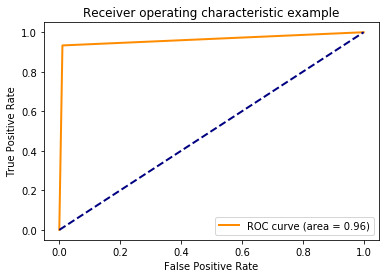

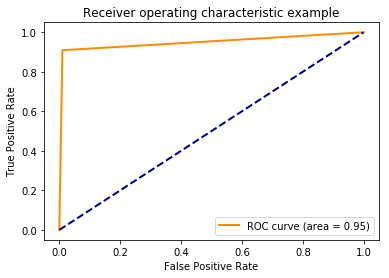

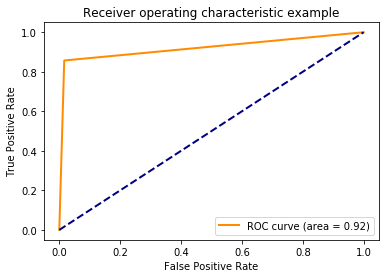

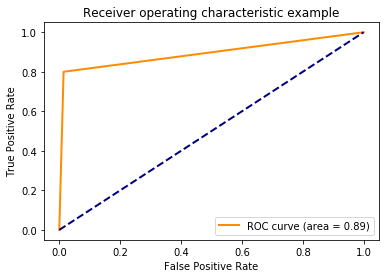

In [31]:
# ROC curve
from sklearn import metrics

for t in range(len(X_test)):
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(X_test_bool[t], X_pred_bool[t])
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    
    plt.figure()
    plt.plot(false_positive_rate, true_positive_rate, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    # plt.xlim([0.0, 1.0])
    # plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()